In [9]:
import tensorflow as tf
import tensorflow_probability.python.distributions as tfp
from collections import deque
import random as rand
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import gym
import scipy.stats as spst

In [10]:
class Policy(object):
    def __init__(self, obssize, actsize, sess, optimizer):
        """
        obssize: size of the states
        actsize: size of the actions
        """
        # BUILD PREDICTION GRAPH
        # build the input
        state = tf.placeholder(tf.float32, [None, obssize])
        
        initializer = tf.contrib.layers.xavier_initializer()
        W1 = tf.Variable(initializer([obssize, 50]))
        b1 = tf.Variable(initializer([50]))
        W2 = tf.Variable(initializer([50, actsize]))
        b2 = tf.Variable(initializer([actsize]))
        
        h1 = tf.nn.sigmoid(tf.matmul(state, W1) + b1)
        h = tf.matmul(h1, W2) + b2
        
        prob = tf.nn.softmax(h, axis=1)  # prob is of shape [None, actsize], axis should be the one for each sample = axis = 1
        probs_buffer = tf.placeholder(tf.float32, [5,None,actsize])
        weights_ = tf.placeholder(tf.float32, [5])
        weights = tf.nn.softmax(weights_)
        
        #########################   KL   ##########################

        X = tfp.Categorical(probs=prob)
        Y = tfp.Categorical(probs=probs_buffer)
        distance = tfp.kl_divergence(X, Y)# a tensor containing the distances of distribution for each state and 
                                          # each policy from the replay buffer dim(5,len(OBS))
        exploration_loss_KL_ = tf.reduce_mean(distance, axis=1)
        exploration_loss_KL = tf.tensordot(exploration_loss_KL_, weights, axes=[0,0])
        
        #########################   L1   ###########################
        Dif_ = probs_buffer - prob
        norm_L1 = tf.norm(Dif_, axis=2,  ord=1)
        exploration_loss_L1_ = tf.reduce_mean(norm_L1, axis=1)
        exploration_loss_L1 = tf.tensordot(exploration_loss_L1_, weights, axes=[0,0])

        #########################   L2   ###########################
        norm_L2 = tf.norm(Dif_ + 1e-5, axis=2,  ord=2)
        exploration_loss_L2_ = tf.reduce_mean(norm_L2, axis=1)
        exploration_loss_L2 = tf.tensordot(exploration_loss_L2_, weights, axes=[0,0])
        
        ########################   Linf   ###########################
        
        norm_Linf = tf.norm(Dif_, axis=2,  ord=np.inf)
        exploration_loss_Linf_ = tf.reduce_mean(norm_Linf, axis=1)
        exploration_loss_Linf = tf.tensordot(exploration_loss_Linf_, weights, axes=[0,0])
        
        ########################   JS   ############################
        
        m = 0.5*(probs_buffer + prob)
        M = tfp.Categorical(probs=m)
        X = tfp.Categorical(probs=prob)
        Y = tfp.Categorical(probs=probs_buffer)
        JS = 0.5* tfp.kl_divergence(X, M) + tfp.kl_divergence(Y, M)
        exploration_loss_JS_ = tf.reduce_mean(JS, axis=1)
        exploration_loss_JS = tf.tensordot(exploration_loss_JS_, weights, axes=[0,0])
        ############################################################
        
        Q_estimate = tf.placeholder(tf.float32, [None])
        actions = tf.placeholder(tf.int32, [None])
        actions_one_hot = tf.one_hot(actions, actsize) # actions_one_hot will be a matrix of shape(n,2)
        action_probabilities = tf.reduce_sum(prob * actions_one_hot, axis=1) # this will connect the action that was 
                                                                             # actually played to to its probability
        
        
        surrogate_loss = -tf.reduce_mean(tf.log(action_probabilities)*Q_estimate)
        explore_alpha = tf.placeholder(tf.float32,[])
        loss_and_exploration_loss_KL = surrogate_loss - explore_alpha*exploration_loss_KL
        loss_and_exploration_loss_L1 = surrogate_loss - explore_alpha*exploration_loss_L1
        loss_and_exploration_loss_L2 = surrogate_loss - explore_alpha*exploration_loss_L2
        loss_and_exploration_loss_Linf = surrogate_loss - explore_alpha*exploration_loss_Linf
        loss_and_exploration_loss_JS = surrogate_loss - explore_alpha*exploration_loss_JS
        self.train_op = optimizer.minimize(surrogate_loss)
        self.train_explore_KL = optimizer.minimize(loss_and_exploration_loss_KL)
        self.train_explore_L1 = optimizer.minimize(loss_and_exploration_loss_L1)
        self.train_explore_L2 = optimizer.minimize(loss_and_exploration_loss_L2)
        self.train_explore_Linf = optimizer.minimize(loss_and_exploration_loss_Linf)
        self.train_explore_JS = optimizer.minimize(loss_and_exploration_loss_JS)
        
        # some bookkeeping
        self.state = state
        self.prob = prob
        self.actions = actions
        self.Q_estimate = Q_estimate
        self.loss = surrogate_loss
        self.optimizer = optimizer
        self.sess = sess
        self.explore_alpha = explore_alpha
        self.exploration_loss_KL = exploration_loss_KL
        self.exploration_loss_L1 = exploration_loss_L1
        self.exploration_loss_L2 = exploration_loss_L2
        self.exploration_loss_Linf = exploration_loss_Linf
        self.exploration_loss_JS = exploration_loss_JS
        self.probs_buffer = probs_buffer
        self.weights = weights
    
    def compute_prob(self, states):
        """
        compute prob over actions given states pi(a|s)
        states: numpy array of size [numsamples, obssize]
        return: numpy array of size [numsamples, actsize]
        """
        return self.sess.run(self.prob, feed_dict={self.state:states})

    def train(self, states, actions, Qs):
        """
        states: numpy array (states)
        actions: numpy array (actions)
        Qs: numpy array (Q values)
        """
        self.sess.run(self.train_op, feed_dict={self.state:states, self.actions:actions, self.Q_estimate:Qs})
        
    def train_expl(self, states, actions, Qs, probs, expl_alpha, weights, distance_metric):
        """
        states: numpy array (states)
        actions: numpy array (actions)
        Qs: numpy array (Q values)
        batch_Q: numpy array as input to compute loss_explore
        exploration_alpha: numpy array as input to loss_and_exploration_loss
        distance_metrix: string representing method to use for exploration
        
        """
        if distance_metric == "KL":
            return self.sess.run(self.train_explore_KL, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.explore_alpha:expl_alpha, self.weights:weights})
        elif distance_metric == "L1":
            return self.sess.run(self.train_explore_L1, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.explore_alpha:expl_alpha, self.weights:weights})
        elif distance_metric == "L2":
            return self.sess.run(self.train_explore_L2, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.explore_alpha:expl_alpha, self.weights:weights})
        
        elif distance_metric == "Linf":
            return self.sess.run(self.train_explore_Linf, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.explore_alpha:expl_alpha, self.weights:weights})
        elif distance_metric == "JS":
            return self.sess.run(self.train_explore_JS, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.explore_alpha:expl_alpha, self.weights:weights})
    
    
    def compute_exploration_loss(self, states, actions, Qs, probs, weights, distance_metric):
        """
        states: numpy array as input to compute loss (s)
        actions: numpy array as input to compute loss (a)
        targets: numpy array as input to compute loss (Q targets)
        batch_Q: numpy array as input to compute loss_explore
        distance_metric: string 
        """
        if distance_metric == "KL":
            return self.sess.run(self.exploration_loss_KL, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.weights:weights})
        elif distance_metric == "L1":
            return self.sess.run(self.exploration_loss_L1, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.weights:weights})
        elif distance_metric == "L2":
            return self.sess.run(self.exploration_loss_L2, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.weights:weights})
        elif distance_metric == "Linf":
            return self.sess.run(self.exploration_loss_Linf, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.weights:weights})
        elif distance_metric == "JS":
            return self.sess.run(self.exploration_loss_JS, feed_dict={self.state:states, self.actions:actions,\
                                                            self.Q_estimate:Qs, self.probs_buffer:probs,\
                                                            self.weights:weights})

In [11]:
# define value function as a class
class ValueFunction(object):
    def __init__(self, obssize, sess, optimizer):
        """
        obssize: size of states
        """
        state = tf.placeholder(tf.float32, [None, obssize])
        
        initializer = tf.contrib.layers.xavier_initializer()
        W1 = tf.Variable(initializer([obssize, 50]))
        b1 = tf.Variable(initializer([50]))
        W2 = tf.Variable(initializer([50, 1]))
        b2 = tf.Variable(initializer([1]))
        
        h1 = tf.nn.sigmoid(tf.matmul(state, W1) + b1) # dim = [num_of_samples, 30]
        predictions = tf.matmul(h1, W2) + b2 # dim = [num_of_samples, 1]
        
        self.predictions = predictions
        self.obssize = obssize
        self.optimizer = optimizer
        self.sess = sess
        self.state = state
        
        
        targets = tf.placeholder(tf.float32, [None])# first None because the number of sampled trajectories
        # is not known beforehand and furthermore, the length of each trajectory might vary and is not constant. 
        # But in the end it is just a list of unkown size where each element is a number representing the value
        # for the corresponding state in self.states
        error = predictions - targets
        loss = tf.reduce_mean(tf.square(error))
        
        self.targets = targets
        self.train_op = optimizer.minimize(loss)

    def compute_values(self, states):
        """
        compute value function for given states
        states: numpy array of size [numsamples, obssize]
        return: numpy array of size [numsamples]
        """
        return self.sess.run(self.predictions, feed_dict={self.state:states})

    def train(self, states, targets):
        """
        states: numpy array
        targets: numpy array
        """
        return self.sess.run(self.train_op, feed_dict={self.state:states, self.targets:targets}) 


In [12]:
def discounted_rewards(r, gamma):
    """ 
    take 1D float array of rewards and compute discounted reward 
    returns a list where the first element is the complete discounted reward for the whole trajectory (already summed),
    the second element is the complete discounted reward for the trajectory starting at t=1 and so on...
    """
    
    discounted_r = np.zeros_like(r)
    running_sum = 0
    for i in reversed(range(0,len(r))):
        discounted_r[i] = running_sum * gamma + r[i]
        running_sum = discounted_r[i]
    return list(discounted_r)

In [13]:
def build_target_update(from_scope, to_scope):
    """
    from_scope: string representing the scope of the network FROM which the variables will be copied
    to_scope: string representing the scope of the network TO which the variables will be copied
    """
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_scope)
    op = []
    for v1, v2 in zip(from_vars, to_vars):
        op.append(v2.assign(v1))
    return op    

In [14]:
# Implement replay buffer
import random
class ReplayBuffer(object):
    
    def __init__(self, maxlength):
        """
        maxlength: max number of tuples to store in the buffer
        if there are more tuples than maxlength, pop out the oldest tuples
        """
        self.buffer = deque()
        self.number = 0
        self.maxlength = maxlength
    
    def append(self, experience):
        """
        this function implements appending new experience tuple
        experience: a tuple of the form (s,a,r,s^\prime)
        """
        self.buffer.append(experience)
        self.number += 1
        
    def pop(self):
        """
        pop out the oldest tuples if self.number > self.maxlength
        """
        while self.number > self.maxlength:
            self.buffer.popleft()
            self.number -= 1
    
    def sample(self, batchsize):
        """
        this function samples 'batchsize' experience tuples
        batchsize: size of the minibatch to be sampled
        return: a list of tuples of form (s,a,r,s^\prime)
        """
        batch = random.sample(self.buffer, batchsize)
            
        return batch
        

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


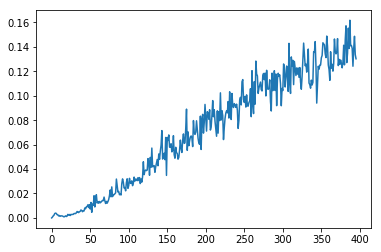

In [15]:
# tune/add hyper-parameters numtrajs too high ? code is very slow
# parameter initializations
alpha = 1e-3  # learning rate for PG
beta = 1e-3  # learning rate for baseline
numtrajs = 15  # num of trajecories to collect at each iteration 
envname = "CartPole-v1"  # environment name
gamma = .99  # discount
episodes = 400 # total num of iterations
maxlength = 5
start = False
exploration_alpha = 0.1
distance_metric = "JS" # Options are: Linf, L1, L2, KL (for Kullback–Leibler divergence), JS (for Jensen–Shannon divergence)
distribution_buffer = "Unif" # Options are: Unif, exp_high_recent, exp_high_old, reward_high
# initialize environment
env = gym.make(envname)
obssize = env.observation_space.low.size
actsize = env.action_space.n

################# DO NOT CHANGE THIS PART ###################
#wrapper for accounting rewards
rEpisode=0
rList=[]

def reset_decorate(func):
    def func_wrapper():
        global rList
        global rEpisode
        rList.append(rEpisode)
        rEpisode=0
        return(func())
    return func_wrapper

env.reset = reset_decorate(env.reset)

def step_decorate(func):
    def func_wrapper(action):
        global rEpisode
        s1, r, d, other = func(action)
        rEpisode+=r
        return(s1, r, d, other)
    return func_wrapper

env.step = step_decorate(env.step)

def init():
    rEpisode=0
    rList=[]
    return;
#########################################################

# sess
sess = tf.Session()

# optimizer
optimizer_p = tf.train.AdamOptimizer(alpha)
optimizer_v = tf.train.AdamOptimizer(beta)

# initialize networks
with tf.variable_scope("actor"):
    actor = Policy(obssize, actsize, sess, optimizer_p)  # policy initialization
    
baseline = ValueFunction(obssize, sess, optimizer_v)  # baseline initialization

with tf.variable_scope("buffer_1"):
    buffer_1 = Policy(obssize, actsize, sess, optimizer_p)  # policy initialization
with tf.variable_scope("buffer_2"):
    buffer_2 = Policy(obssize, actsize, sess, optimizer_p)  # policy initialization
with tf.variable_scope("buffer_3"):
    buffer_3 = Policy(obssize, actsize, sess, optimizer_p)  # policy initialization
with tf.variable_scope("buffer_4"):
    buffer_4 = Policy(obssize, actsize, sess, optimizer_p)  # policy initialization
with tf.variable_scope("buffer_5"):
    buffer_5 = Policy(obssize, actsize, sess, optimizer_p)  # policy initialization
    
update1 = build_target_update("actor", "buffer_1")
update2 = build_target_update("actor", "buffer_2")
update3 = build_target_update("actor", "buffer_3")
update4 = build_target_update("actor", "buffer_4")
update5 = build_target_update("actor", "buffer_5")

# initialize tensorflow graphs
sess.run(tf.global_variables_initializer())
buffer = ReplayBuffer(maxlength)
buffer_count = 1

#logging info
exploration_loss_log = np.array([])
exploration_alpha_log = np.array([])
avg_reward_per_policy = []
reward_buffer_1, reward_buffer_2, reward_buffer_3, reward_buffer_4, reward_buffer_5 = 0,0,0,0,0
# main iteration
for ite in range(episodes):    

    # trajs records for batch update
    OBS = []  # observations
    ACTS = []  # actions
    ADS = []  # advantages (to update policy)
    VAL = []  # value functions (to update baseline)

    for num in range(numtrajs):
        # record for each episode
        obss = []  # observations
        acts = []   # actions
        rews = []  # instant rewards

        obs = env.reset()
        done = False

        while not done:

            prob = actor.compute_prob(np.expand_dims(obs,0))
            action = np.random.choice(actsize, p=prob.flatten(), size=1)
            newobs, reward, done, _ = env.step(action[0])

            # record
            obss.append(obs)
            acts.append(action[0])
            rews.append(reward)
            #print(reward)

            # update
            obs = newobs

        # compute returns from instant rewards for one whole trajectory
        returns = discounted_rewards(rews, gamma)
        avg_reward_per_policy += [sum(returns)]
    
        # record for batch update
        VAL += returns # NOTE that the list of returns just gets extended. 
                       # There is no separate entry created for each trajectory
        OBS += obss
        ACTS += acts         
    
    # update baseline
    VAL = np.array(VAL)# represents an array where the discounted reward lists are concatenated to each other.
    # the size of VAL should be [numtrajs * len_of_traj_i, 1] where len_of_traj_i is variable depending on the length 
    # of each trajectory.
    OBS = np.array(OBS)# represents an array where the list of states for all trajectories are concatenated.
    # the size of OBS should be [numtrajs * len_of_traj_i, obssize]
    ACTS = np.array(ACTS)
    
    baseline.train(OBS, VAL)  # update only one step
    
    # update policy
    BAS = baseline.compute_values(OBS)  # compute baseline for variance reduction
    ADS = VAL - np.squeeze(BAS,1) # computes advantages. An array of (targets)-(estimated from our network) for each
                                  # state
     
    if buffer_count==1 :
        sess.run(update1)
        buffer_count += 1
        reward_buffer_1 = sum(avg_reward_per_policy)
    elif buffer_count==2 :
        sess.run(update2)
        buffer_count += 1
        reward_buffer_2 = sum(avg_reward_per_policy)
    elif buffer_count==3 :
        sess.run(update3)
        buffer_count += 1
        reward_buffer_3 = sum(avg_reward_per_policy)
    elif buffer_count==4 :
        sess.run(update4)
        buffer_count += 1
        reward_buffer_4 = sum(avg_reward_per_policy)
    elif buffer_count==5 :
        sess.run(update5)
        start = True
        buffer_count = 0
        reward_buffer_5 = sum(avg_reward_per_policy)
        
    if distribution_buffer == "Unif":
        weights = np.array([1,1,1,1,1])
    elif distribution_buffer == "exp_high_recent": # recent experience has a bigger historic order value
            weights = np.roll(np.array([1,2,3,4,5]), buffer_count)
    elif distribution_buffer == "exp_high_older": # older experience has a bigger historic order value                      
            weights = np.roll(np.array([5,4,3,2,1]), buffer_count)
    elif distribution_buffer == "reward_high": # experience with high reward has a bigger historic order value                      
            weights = np.array([reward_buffer_1, reward_buffer_2, reward_buffer_3, reward_buffer_4, reward_buffer_5])
    avg_reward_per_policy = []
            
    if start:    
        prob1 = buffer_1.compute_prob(OBS)
        prob2 = buffer_2.compute_prob(OBS)
        prob3 = buffer_3.compute_prob(OBS)
        prob4 = buffer_4.compute_prob(OBS)
        prob5 = buffer_5.compute_prob(OBS)
        probs_buffer = [prob1, prob2, prob3, prob4, prob5] # a tensor of dimension(5,len(OBS), 2)
        
        exploration_loss_log = np.append(exploration_loss_log, actor.compute_exploration_loss(
                OBS, ACTS, ADS, probs_buffer, weights, distance_metric))
        exploration_alpha_log = np.append(exploration_alpha_log, exploration_alpha)

        actor.train_expl(OBS, ACTS, ADS, probs_buffer, exploration_alpha, weights, distance_metric) # update only one step
        
plt.plot(exploration_loss_log)
plt.show()
#plt.plot(exploration_alpha_log)
#plt.show()

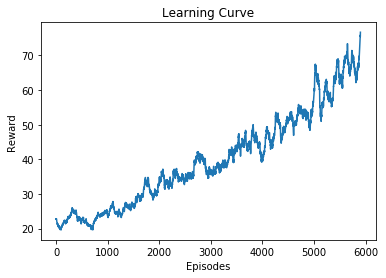

In [16]:
# Code Evaluation: DO NOT CHANGE CODE HERE
from numpy import convolve, ones
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'valid')
from pylab import plot
%matplotlib inline 

rm=movingaverage(rList, 100)
plot(rm)
plt.title("Learning Curve")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

In [17]:
# Code Evaluation: DO NOT CHANGE CODE HERE
# after training, we will evaluate the performance of the agent
# on a target environment
eval_episodes = 100
record = []
env = gym.make('CartPole-v1')
eval_mode = True
for ite in range(eval_episodes):
    
    obs = env.reset()
    done = False
    rsum = 0
    
    while not done:
        
        # epsilon greedy for exploration
        if eval_mode:
            p = actor.compute_prob(np.expand_dims(obs,0)).ravel()
            action = np.random.choice(np.arange(2), size=1, p=p)[0]
        else:
            raise NotImplementedError

        newobs, r, done, _ = env.step(action)
        rsum += r
        obs = newobs
    
    record.append(rsum)

print("eval performance of PG agent: {}".format(np.mean(record)))

eval performance of PG agent: 73.24
